<a href="https://colab.research.google.com/github/abebebelay/AI-for-Climate-Action-Innovation-Research-Network/blob/main/guides/linked/ee-api-colab-setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2019 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/google/earthengine-community/blob/master/guides/linked/ee-api-colab-setup.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/google/earthengine-community/blob/master/guides/linked/ee-api-colab-setup.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Earth Engine Python API Colab Setup

This notebook demonstrates how to setup the Earth Engine Python API in Colab and provides several examples of how to print and visualize Earth Engine processed data.

## Import API and get credentials

The Earth Engine API is installed by default in Google Colaboratory so requires only importing and authenticating. These steps must be completed for each new Colab session, if you restart your Colab kernel, or if your Colab virtual machine is recycled due to inactivity.

### Import the API

Run the following cell to import the API into your session.

In [ ]:
import ee

### Authenticate and initialize

Run the `ee.Authenticate` function to authenticate your access to Earth Engine servers and `ee.Initialize` to initialize it. Upon running the following cell you'll be asked to grant Earth Engine access to your Google account. Follow the instructions printed to the cell.

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='my-project')

## Test the API

Test the API by printing the elevation of Mount Everest.

In [ ]:
# Print the elevation of Mount Everest.
dem = ee.Image('USGS/SRTMGL1_003')
xy = ee.Geometry.Point([86.9250, 27.9881])
elev = dem.sample(xy, 30).first().get('elevation').getInfo()
print('Mount Everest elevation (m):', elev)

## Map visualization

`ee.Image` objects can be displayed to notebook output cells. The following two
examples demonstrate displaying a static image and an interactive map.


### Static image

The `IPython.display` module contains the `Image` function, which can display
the results of a URL representing an image generated from a call to the Earth
Engine `getThumbUrl` function. The following cell will display a thumbnail
of the global elevation model.

In [ ]:
# Import the Image function from the IPython.display module.
from IPython.display import Image

# Display a thumbnail of global elevation.
Image(url = dem.updateMask(dem.gt(0))
  .getThumbURL({'min': 0, 'max': 4000, 'dimensions': 512,
                'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}))

### Interactive map

The [geemap](https://github.com/gee-community/geemap)
library can be used to display `ee.Image` objects on an interactive
[ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet) map.

The following cell provides an example of using the `geemap.Map` object to
display an elevation model.

In [ ]:
# Import the geemap library.
import geemap

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000,
  'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

# Create a map object.
m = geemap.Map(center=[20, 0], zoom=3)

# Add the elevation model to the map object.
m.add_ee_layer(dem.updateMask(dem.gt(0)), vis_params, 'DEM')

# Display the map.
display(m)

## Chart visualization

Some Earth Engine functions produce tabular data that can be plotted by
data visualization packages such as `matplotlib`. The following example
demonstrates the display of tabular data from Earth Engine as a scatter
plot. See [Charting in Colaboratory](https://colab.sandbox.google.com/notebooks/charts.ipynb)
for more information.

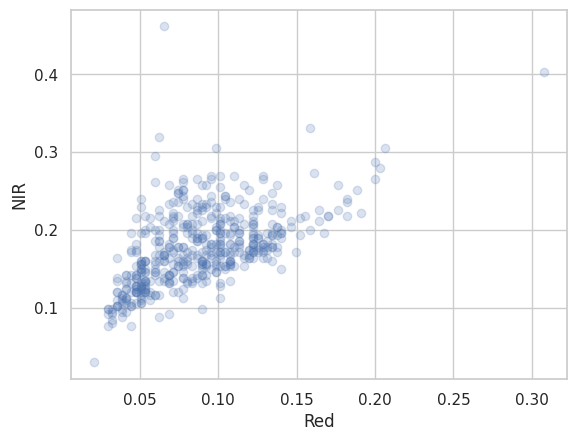

In [16]:
# Import the matplotlib.pyplot module.
import matplotlib.pyplot as plt

# Fetch a Landsat TOA image.
img = ee.Image('LANDSAT/LT05/C02/T1_TOA/LT05_034033_20000913')

# Select Red and NIR bands and sample 500 points.
samp_fc = img.select(['B3','B4']).sample(scale=30, numPixels=500)

# Arrange the sample as a list of lists.
samp_dict = samp_fc.reduceColumns(ee.Reducer.toList().repeat(2), ['B3', 'B4'])
samp_list = ee.List(samp_dict.get('list'))

# Save server-side ee.List as a client-side Python list.
samp_data = samp_list.getInfo()

# Display a scatter plot of Red-NIR sample pairs using matplotlib.
plt.scatter(samp_data[0], samp_data[1], alpha=0.2)
plt.xlabel('Red', fontsize=12)
plt.ylabel('NIR', fontsize=12)
plt.show()

In [17]:
import ee
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Authenticate and Initialize Earth Engine ===
ee.Authenticate()
ee.Initialize(project='plexiform-dream-464118-a2')

# === 2. Define Miami area and get Landsat 8 SR image ===
miami = ee.Geometry.Rectangle([-80.35, 25.70, -80.10, 25.85])

# Get least cloudy image in July 2022
landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(miami) \
    .filterDate('2022-07-01', '2022-07-31') \
    .filter(ee.Filter.lt('CLOUD_COVER', 20)) \
    .sort('CLOUD_COVER') \
    .first()

# === 3. Convert bands to TOA reflectance using expression ===
# Landsat 8 Collection 2 surface reflectance scale: TOA = SR_Bx * 0.0000275 - 0.2
red = ee.Image(landsat).select('SR_B4').multiply(0.0000275).add(-0.2).rename('Red')
nir = ee.Image(landsat).select('SR_B5').multiply(0.0000275).add(-0.2).rename('NIR')

# === 4. Compute NDVI ===
ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

# === 5. Sample NDVI and Red reflectance ===
sample = ndvi.addBands(red).sample(
    region=miami,
    scale=30,
    numPixels=1000,
    seed=1,
    geometries=False
)

sample_list = ee.List(
    sample.reduceColumns(
        reducer=ee.Reducer.toList().repeat(2),
        selectors=['NDVI', 'Red']
    ).get('list')
)

samples = sample_list.getInfo()

# === 6. Extract data into lists ===
ndvi_vals = [pt[0] for pt in samples]
red_vals = [pt[1] for pt in samples]

# === 7. Plotting ===
sns.set(style='whitegrid')

# --- NDVI vs Red Scatter Plot ---
plt.figure(figsize=(8, 6))
plt.scatter(red_vals, ndvi_vals, alpha=0.3, s=30, color='crimson', edgecolor='gray')
plt.title('NDVI vs Red Reflectance (Miami, Landsat 8)', fontsize=14)
plt.xlabel('Red Band Reflectance (SR_B4)', fontsize=12)
plt.ylabel('NDVI', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('NDVI_vs_Red.png', dpi=300)
plt.savefig('NDVI_vs_Red.pdf')
plt.show()

# --- NDVI Histogram ---
plt.figure(figsize=(8, 6))
sns.histplot(ndvi_vals, bins=40, kde=True, color='green', edgecolor='black')
plt.title('NDVI Histogram (Miami, Landsat 8)', fontsize=14)
plt.xlabel('NDVI', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.savefig('NDVI_Histogram.png', dpi=300)
plt.savefig('NDVI_Histogram.pdf')
plt.show()

print("✅ Plots saved: NDVI_vs_Red.[png/pdf], NDVI_Histogram.[png/pdf]")


AttributeError: 'Element' object has no attribute 'normalizedDifference'